This case study is to study airlines data for cancellation prediction

The study does not provide best cancellation prediction model but its an intent to come up with an analysis path for such prediction.
### **Problem definition**: 
With the following data in hand predict flight cancellation


1.   Flight take off and landling details history with weather data
2.   Airlines details
3.   Airport details

**Business constraints:**
No constrain of low latency
Accuracy is needed

**Key perfomance metric**:
F1 score



In [30]:
from google.colab import drive
drive.mount('/content/gdrive')
import pandas as pd
import datetime
import time
from time import strftime, gmtime

df_airport = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/airports.csv')
df_flights = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/flights.csv')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Lets find the following about data
1. Whats the count of flight data in each class (Delayed / not delayed)
2. How many flights are actually delayed
3. Which airline has worst cancellation rate.
4. does weather has any impact on cancellation
5. which airline has got most impact due to weather.

In [0]:

# flight.AIRLINE_DELAY SCHEDULED_ARRIVAL - ARRIVAL_TIME

import numpy as np

# converting input time value to datetime.
def conv_time(time_val):
    if pd.isnull(time_val):
        return np.nan
    else:
            # replace 24:00 o'clock with 00:00 o'clock:
        if time_val == 2400: time_val = 0
            # creating a 4 digit value out of input value:
        time_val = "{0:04d}".format(int(time_val))
            # creating a time datatype out of input value: 
        time_formatted = datetime.time(int(time_val[0:2]), int(time_val[2:4]))
    return time_formatted

def compute_delay(time_val,sch_arrival,act_arrival):
    if pd.isnull(time_val):
        return act_arrival-sch_arrival
    

In [0]:
df_flights['ARRIVAL_TIME'] = df_flights['ARRIVAL_TIME'].apply(conv_time)
df_flights['DEPARTURE_TIME'] = df_flights['DEPARTURE_TIME'].apply(conv_time)
df_flights['SCHEDULED_DEPARTURE'] = df_flights['SCHEDULED_DEPARTURE'].apply(conv_time)
df_flights['WHEELS_OFF'] = df_flights['WHEELS_OFF'].apply(conv_time)
df_flights['WHEELS_ON'] = df_flights['WHEELS_ON'].apply(conv_time)
df_flights['SCHEDULED_ARRIVAL'] = df_flights['SCHEDULED_ARRIVAL'].apply(conv_time)


In [33]:
#df_flights['ARRIVAL_DELAY'] = df_flights['ARRIVAL_DELAY'].apply(compute_delay)

#df_flights['ARRIVAL_DELAY'] = df_flights.apply(lambda df_flights: compute_delay(df_flights.ARRIVAL_DELAY, df_flights.SCHEDULED_ARRIVAL,df_flights.ARRIVAL_TIME), axis=1)
pd.set_option('display.max_columns', 500)
df_flights.loc[df_flights['AIRLINE_DELAY'].notnull(), ['AIRLINE_DELAY','AIR_SYSTEM_DELAY','SECURITY_DELAY','AIRLINE_DELAY','LATE_AIRCRAFT_DELAY','WEATHER_DELAY']].head()

,AIRLINE_DELAY,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
27,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000
30,0.000000,43.000000,0.000000,0.000000,0.000000,0.000000
35,15.000000,0.000000,0.000000,15.000000,0.000000,0.000000
50,0.000000,20.000000,0.000000,0.000000,0.000000,0.000000
52,85.000000,0.000000,0.000000,85.000000,0.000000,0.000000


In [34]:
df_flights.loc[df_flights['CANCELLATION_REASON'].notnull(),['CANCELLATION_REASON']].head(15)
df_flights['CANCELLATION_REASON'].value_counts()

# -------------------------------------
# converting categoric value to numeric
df_flights.loc[df_flights['CANCELLATION_REASON'] == 'A', 'CANCELLATION_REASON'] = 1
df_flights.loc[df_flights['CANCELLATION_REASON'] == 'B', 'CANCELLATION_REASON'] = 2
df_flights.loc[df_flights['CANCELLATION_REASON'] == 'C', 'CANCELLATION_REASON'] = 3
df_flights.loc[df_flights['CANCELLATION_REASON'] == 'D', 'CANCELLATION_REASON'] = 4

# -----------------------------------
# converting NaN data to numeric zero
df_flights['CANCELLATION_REASON'] = df_flights['CANCELLATION_REASON'].fillna(0)
# drop the missing values
df_flights = df_flights.dropna(axis=0)

df_times = df_flights[
[
    'SCHEDULED_DEPARTURE',
    'DEPARTURE_TIME',
    'DEPARTURE_DELAY',
    'TAXI_OUT',
    'WHEELS_OFF',
    'SCHEDULED_TIME',
    'ELAPSED_TIME',
    'AIR_TIME',
    'DISTANCE',
    'WHEELS_ON',
    'TAXI_IN',
    'SCHEDULED_ARRIVAL',
    'ARRIVAL_TIME',
    'ARRIVAL_DELAY',
    'DIVERTED',
    'CANCELLED',
    'CANCELLATION_REASON',
    'AIR_SYSTEM_DELAY',
    'SECURITY_DELAY',
    'AIRLINE_DELAY',
    'LATE_AIRCRAFT_DELAY',
    'WEATHER_DELAY'
]]
pd.set_option('float_format', '{:f}'.format)

df_times.describe()

,DEPARTURE_DELAY,TAXI_OUT,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,TAXI_IN,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
count,1063439.000000,1063439.000000,1063439.000000,1063439.000000,1063439.000000,1063439.000000,1063439.000000,1063439.000000,1063439.000000,1063439.000000,1063439.000000,1063439.000000,1063439.000000,1063439.000000,1063439.000000,1063439.000000
mean,54.947912,20.725983,142.963733,146.930217,117.415979,832.604466,8.788255,58.914397,0.000000,0.000000,0.000000,13.480568,0.076154,18.969547,23.472838,2.915290
std,67.219081,14.787387,75.237291,77.387621,74.163584,606.761207,8.943844,64.250318,0.000000,0.000000,0.000000,28.003679,2.143460,48.161642,43.197018,20.433336
min,-32.000000,1.000000,18.000000,16.000000,8.000000,31.000000,1.000000,15.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,17.000000,12.000000,86.000000,90.000000,62.000000,383.000000,4.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,37.000000,16.000000,125.000000,129.000000,99.000000,674.000000,6.000000,37.000000,0.000000,0.000000,0.000000,2.000000,0.000000,2.000000,3.000000,0.000000
75%,70.000000,24.000000,175.000000,181.000000,149.000000,1069.000000,9.000000,70.000000,0.000000,0.000000,0.000000,18.000000,0.000000,19.000000,29.000000,0.000000
max,1988.000000,225.000000,718.000000,766.000000,690.000000,4983.000000,248.000000,1971.000000,0.000000,0.000000,0.000000,1134.000000,573.000000,1971.000000,1331.000000,1211.000000


In [35]:
df_airlines = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/airlines.csv')
df_flights = df_flights.merge(df_airlines, left_on='AIRLINE', right_on='IATA_CODE', how='inner')
df_flights.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE_x,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,IATA_CODE,AIRLINE_y
0,2015,1,1,4,NK,597,N528NK,MSP,FLL,01:15:00,01:27:00,12.000000,14.000000,01:41:00,207.000000,220.000000,166.000000,1487,05:27:00,40.000000,05:42:00,06:07:00,25.000000,0,0,0,25.000000,0.000000,0.000000,0.000000,0.000000,NK,Spirit Air Lines
1,2015,1,1,4,NK,168,N629NK,PHX,ORD,01:25:00,02:37:00,72.000000,9.000000,02:46:00,204.000000,175.000000,156.000000,1440,06:22:00,10.000000,05:49:00,06:32:00,43.000000,0,0,0,43.000000,0.000000,0.000000,0.000000,0.000000,NK,Spirit Air Lines
2,2015,1,1,4,NK,224,N607NK,ORD,LGA,05:56:00,05:47:00,-9.000000,16.000000,06:03:00,124.000000,160.000000,92.000000,733,08:35:00,52.000000,09:00:00,09:27:00,27.000000,0,0,0,27.000000,0.000000,0.000000,0.000000,0.000000,NK,Spirit Air Lines
3,2015,1,1,4,NK,943,N605NK,ACY,RSW,06:00:00,07:42:00,102.000000,10.000000,07:52:00,171.000000,155.000000,141.000000,982,10:13:00,4.000000,08:51:00,10:17:00,86.000000,0,0,0,86.000000,0.000000,0.000000,0.000000,0.000000,NK,Spirit Air Lines
4,2015,1,1,4,NK,316,N601NK,DTW,LGA,06:00:00,05:58:00,-2.000000,11.000000,06:09:00,98.000000,158.000000,67.000000,502,07:16:00,80.000000,07:38:00,08:36:00,58.000000,0,0,0,58.000000,0.000000,0.000000,0.000000,0.000000,NK,Spirit Air Lines


In [0]:

df_flights = df_flights.drop(['AIRLINE_x','IATA_CODE'], axis=1)
df_flights = df_flights.rename(columns={"AIRLINE_y":"AIRLINE"})
#mask = df_flights.AIRLINE_DELAY > 15
#column_name = 'IF_DELAYED'



In [37]:
df_flights['IF_DELAYED'] = 0
df_flights.loc[df_flights.AIRLINE_DELAY > 15, 'IF_DELAYED'] = 1

#print(df_flights.loc[df_flights.IF_DELAYED == 1])

         YEAR  MONTH  DAY  DAY_OF_WEEK  FLIGHT_NUMBER TAIL_NUMBER  \
728      2015      1    6            2            720      N528NK   
913      2015      1    8            4            939      N607NK   
949      2015      1    8            4            245      N512NK   
980      2015      1    8            4            240      N622NK   
1003     2015      1    9            5            972      N611NK   
1010     2015      1    9            5            567      N505NK   
1011     2015      1    9            5            121      N620NK   
1013     2015      1    9            5            198      N625NK   
1020     2015      1    9            5            858      N510NK   
1023     2015      1    9            5            107      N607NK   
1032     2015      1    9            5            649      N624NK   
1035     2015      1    9            5            733      N505NK   
1038     2015      1    9            5            511      N533NK   
1041     2015      1    9         

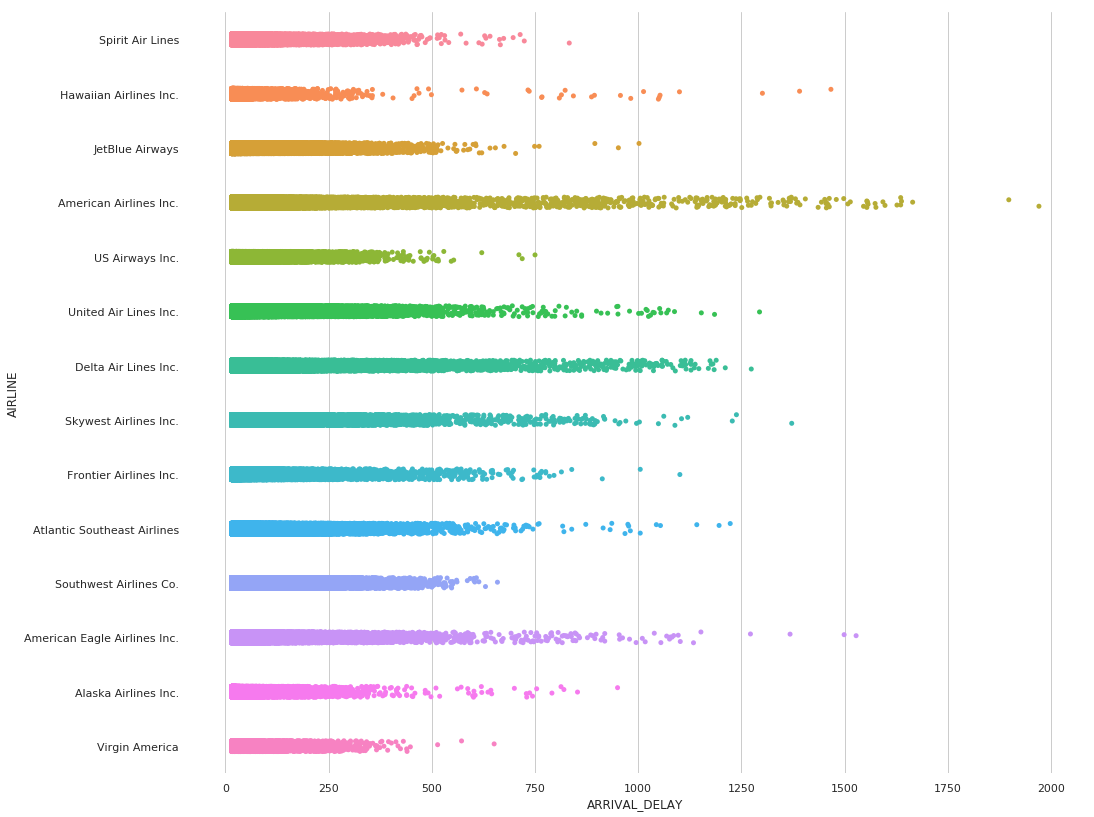

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt


sns.set(style="whitegrid")

# initialize the figure
fig_dim = (16,14)
f, ax = plt.subplots(figsize=fig_dim)
sns.despine(bottom=True, left=True)

# Show each observation with a scatterplot
sns.stripplot(x="ARRIVAL_DELAY", y="AIRLINE",
              data=df_flights, dodge=True, jitter=True
            )



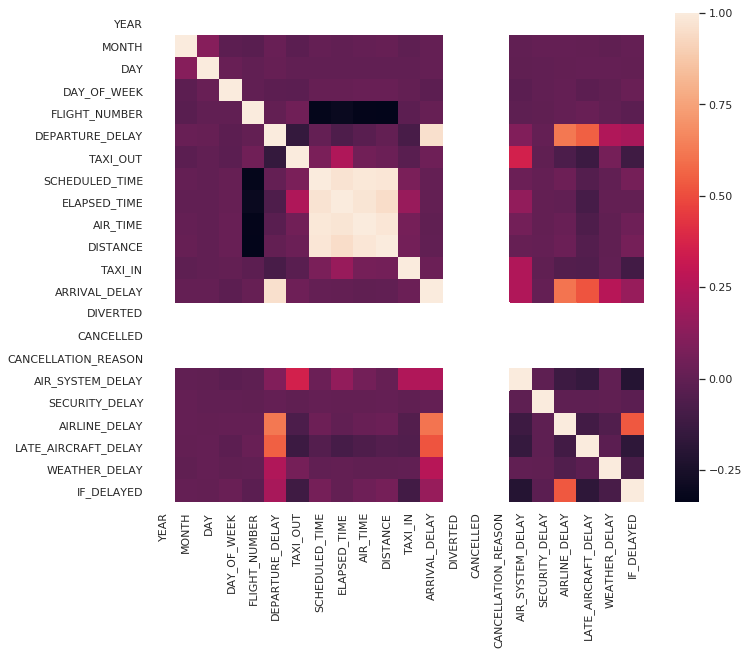

In [39]:
# Feature selection using SKLearn
# Dataframe correlation
del_corr = df_flights.corr()

# Draw the figure
f, ax = plt.subplots(figsize=(11, 9))

# Draw the heatmap
sns.heatmap(del_corr)

In [40]:


# Only using data from January
df_flights_jan = df_flights.loc[(df_flights.loc[:,'YEAR'] == 2015 ) & (df_flights.loc[:,'MONTH'] == 1 )]

df_flights_jan.head()


,YEAR,MONTH,DAY,DAY_OF_WEEK,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,AIRLINE,IF_DELAYED
0,2015,1,1,4,597,N528NK,MSP,FLL,01:15:00,01:27:00,12.000000,14.000000,01:41:00,207.000000,220.000000,166.000000,1487,05:27:00,40.000000,05:42:00,06:07:00,25.000000,0,0,0,25.000000,0.000000,0.000000,0.000000,0.000000,Spirit Air Lines,0
1,2015,1,1,4,168,N629NK,PHX,ORD,01:25:00,02:37:00,72.000000,9.000000,02:46:00,204.000000,175.000000,156.000000,1440,06:22:00,10.000000,05:49:00,06:32:00,43.000000,0,0,0,43.000000,0.000000,0.000000,0.000000,0.000000,Spirit Air Lines,0
2,2015,1,1,4,224,N607NK,ORD,LGA,05:56:00,05:47:00,-9.000000,16.000000,06:03:00,124.000000,160.000000,92.000000,733,08:35:00,52.000000,09:00:00,09:27:00,27.000000,0,0,0,27.000000,0.000000,0.000000,0.000000,0.000000,Spirit Air Lines,0
3,2015,1,1,4,943,N605NK,ACY,RSW,06:00:00,07:42:00,102.000000,10.000000,07:52:00,171.000000,155.000000,141.000000,982,10:13:00,4.000000,08:51:00,10:17:00,86.000000,0,0,0,86.000000,0.000000,0.000000,0.000000,0.000000,Spirit Air Lines,0
4,2015,1,1,4,316,N601NK,DTW,LGA,06:00:00,05:58:00,-2.000000,11.000000,06:09:00,98.000000,158.000000,67.000000,502,07:16:00,80.000000,07:38:00,08:36:00,58.000000,0,0,0,58.000000,0.000000,0.000000,0.000000,0.000000,Spirit Air Lines,0


In [43]:
df_flights_jan['DELAYED'] = df_flights_jan.loc[:,'ARRIVAL_DELAY'].values > 0
# Label definition
df_flights_jan.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,YEAR,MONTH,DAY,DAY_OF_WEEK,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,AIRLINE,IF_DELAYED,DELAYED
0,2015,1,1,4,597,N528NK,MSP,FLL,01:15:00,01:27:00,12.000000,14.000000,01:41:00,207.000000,220.000000,166.000000,1487,05:27:00,40.000000,05:42:00,06:07:00,25.000000,0,0,0,25.000000,0.000000,0.000000,0.000000,0.000000,Spirit Air Lines,0,True
1,2015,1,1,4,168,N629NK,PHX,ORD,01:25:00,02:37:00,72.000000,9.000000,02:46:00,204.000000,175.000000,156.000000,1440,06:22:00,10.000000,05:49:00,06:32:00,43.000000,0,0,0,43.000000,0.000000,0.000000,0.000000,0.000000,Spirit Air Lines,0,True
2,2015,1,1,4,224,N607NK,ORD,LGA,05:56:00,05:47:00,-9.000000,16.000000,06:03:00,124.000000,160.000000,92.000000,733,08:35:00,52.000000,09:00:00,09:27:00,27.000000,0,0,0,27.000000,0.000000,0.000000,0.000000,0.000000,Spirit Air Lines,0,True
3,2015,1,1,4,943,N605NK,ACY,RSW,06:00:00,07:42:00,102.000000,10.000000,07:52:00,171.000000,155.000000,141.000000,982,10:13:00,4.000000,08:51:00,10:17:00,86.000000,0,0,0,86.000000,0.000000,0.000000,0.000000,0.000000,Spirit Air Lines,0,True
4,2015,1,1,4,316,N601NK,DTW,LGA,06:00:00,05:58:00,-2.000000,11.000000,06:09:00,98.000000,158.000000,67.000000,502,07:16:00,80.000000,07:38:00,08:36:00,58.000000,0,0,0,58.000000,0.000000,0.000000,0.000000,0.000000,Spirit Air Lines,0,True


In [53]:
y = df_flights_jan.DELAYED

from sklearn.ensemble import RandomForestClassifier
# Choosing the predictors
feature_list_s = [
    'LATE_AIRCRAFT_DELAY'
    ,'AIRLINE_DELAY'
    ,'AIR_SYSTEM_DELAY'
    ,'WEATHER_DELAY'
    ,'ELAPSED_TIME']

# New dataframe based on a small feature list
X_small = df_flights_jan[feature_list_s]
print(X_small.shape)
print(y.shape)
# RandomForestClassifier with 10 trees and fitted on the small feature set 
clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=4, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)
clf.fit(X_small, y)
print(clf.feature_importances_)
# Extracting feature importance for each feature
i=0
df_feature_small = pd.DataFrame(columns=['FEATURE','IMPORTANCE'])
for val in (clf.feature_importances_):
    df_feature_small.loc[i] = [feature_list_s[i],val]
    i = i + 1
    

df_feature_small.sort_values('IMPORTANCE', ascending=False)

(95951, 5)
(95951,)
[0. 0. 0. 0. 0.]


,FEATURE,IMPORTANCE
0,LATE_AIRCRAFT_DELAY,0.000000
1,AIRLINE_DELAY,0.000000
2,AIR_SYSTEM_DELAY,0.000000
3,WEATHER_DELAY,0.000000
4,ELAPSED_TIME,0.000000
